<a href="https://colab.research.google.com/github/sdikici/Demand_Forecasting_Prophet_DeepAR/blob/main/DeepAR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d sercandikici/merged-dataset-electricty-weather-for-modelling
! unzip merged-dataset-electricty-weather-for-modelling.zip

Dataset URL: https://www.kaggle.com/datasets/sercandikici/merged-dataset-electricty-weather-for-modelling
License(s): unknown
100% 104k/104k [00:00<00:00, 542kB/s]
100% 104k/104k [00:00<00:00, 541kB/s]
Archive:  merged-dataset-electricty-weather-for-modelling.zip
  inflating: merged_data.csv         


In [ ]:
!pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.4 MB/s eta 0:00:00


In [ ]:
pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [ ]:
pip install mxnet --upgrade

In [ ]:
import numpy as np
np.bool = np.bool_

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon
import json
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def r_squared(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [ ]:
df_merged = pd.read_csv("merged_data.csv")
df_merged['settlement_date'] = pd.to_datetime(df_merged['settlement_date'])
df_merged

,settlement_date,tsd,is_holiday,temp
0,2021-01-01 00:00:00,28552.00,1.0,1.55
1,2021-01-01 02:00:00,26579.75,1.0,1.60
2,2021-01-01 04:00:00,25236.00,1.0,0.55
3,2021-01-01 06:00:00,25792.25,1.0,-0.35
4,2021-01-01 08:00:00,28162.75,1.0,-0.10
...,...,...,...,...
13136,2023-12-31 16:00:00,34006.00,0.0,7.60
13137,2023-12-31 18:00:00,32273.00,0.0,8.20
13138,2023-12-31 20:00:00,27456.50,0.0,8.45
13139,2023-12-31 22:00:00,24139.25,0.0,8.35


In [ ]:
df_model_1 = df_merged[["tsd","settlement_date"]]
df_model_1= df_model_1.set_index("settlement_date")
df_model_1

,tsd
settlement_date,
2021-01-01 00:00:00,28552.00
2021-01-01 02:00:00,26579.75
2021-01-01 04:00:00,25236.00
2021-01-01 06:00:00,25792.25
2021-01-01 08:00:00,28162.75
...,...
2023-12-31 16:00:00,34006.00
2023-12-31 18:00:00,32273.00
2023-12-31 20:00:00,27456.50


In [ ]:
split_from = 90*12 #train test split is from 90days

train_data = df_model_1[:-split_from]
test_data = df_model_1[-split_from:]
print(train_data.shape)
print(test_data.shape)

(12061, 1)
(1080, 1)


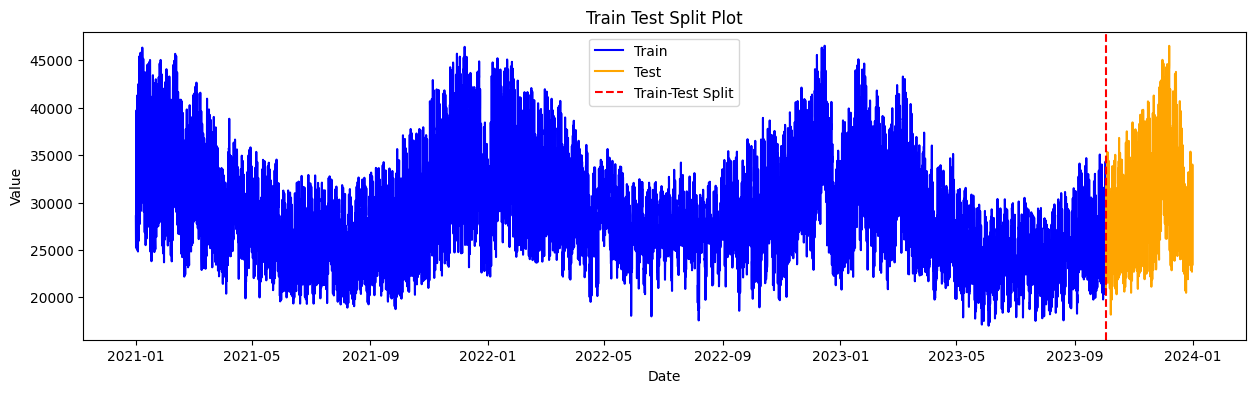

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(train_data.index,train_data["tsd"],color="blue", label="Train")
plt.plot(test_data.index,test_data["tsd"], color="orange", label="Test")
plt.axvline(train_data.index[-1], color="red", linestyle="--", label="Train-Test Split")

plt.title('Train Test Split Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
freq = "2H"
days_to_predict=15 #days
prediction_length = days_to_predict*12
context_length = prediction_length *3
num_layers = 2
num_cells = 128
epochs = 18
num_batches_per_epoch = 200
dropout_rate = 0.1


In [ ]:
estimator = DeepAREstimator (freq=freq,
                             context_length=context_length,
                             prediction_length=prediction_length,
                             num_layers=num_layers,
                             num_cells=num_cells,
                             dropout_rate=dropout_rate,
                             trainer= Trainer(
                                 epochs=epochs,
                                 num_batches_per_epoch=num_batches_per_epoch
                                              )
                                              )

In [ ]:
train_ds = ListDataset(
    [{"start":train_data.index[0],
      "target":train_data.tsd}],
    freq=freq)

In [ ]:
mx.random.seed(7)
np.random.seed(7)
m1 = estimator.train(training_data=train_ds)

  0%|          | 0/150 [00:09<?, ?it/s]
/usr/local/lib/python3.10/dist-packages/gluonts/mx/trainer/_base.py:484: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(


UnboundLocalError: local variable 'epoch_loss' referenced before assignment

create subset of test data for testing

In [ ]:
test_ds = ListDataset(
    [{"start":test_data.index[0],
      "target":test_data.tsd}],
    freq=freq)

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds,
    predictor=m1,
    num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)

NameError: name 'test_ds' is not defined

create forecasts df

In [ ]:
start_date = forecasts[0].start_date.start_time
samples = forecasts[0].quantile(0.5).T
index = pd.date_range(start=start_date, periods=len(samples), freq=freq)
forecast_df = pd.DataFrame(samples, index=index)
forecast_df.columns = ["median_prediction"]


In [ ]:
test_days = test_data[(test_data.index >= forecast_df.index[0])&(test_data.index <= forecast_df.index[-1])]


In [ ]:
def forecast_plot(forecast_days,test_days, days):

  fig, ax = plt.subplots(figsize=(14, 4))
  ax.plot(forecast_df.index, forecast_df['median_prediction'], label='Forecast', color='green')
  ax.scatter(test_days.index, test_days['tsd'], label='Actual', color='orange')
  ax.set_xlabel('Date')
  ax.set_ylabel('MGW')
  plt.title(f'DeepAR Forecast - {days} days')
  plt.legend()
  plt.show()

forecast_plot(forecast_df,test_days,days_to_predict)

NameError: name 'forecast_df' is not defined

In [ ]:
mape_1 = mean_absolute_percentage_error(test_days["tsd"],forecast_df["median_prediction"])
rmse_1 = root_mean_squared_error(test_days["tsd"],forecast_df["median_prediction"])
rsqr_1 = r_squared(test_days["tsd"],forecast_df["median_prediction"])
print(f"MAPE without regressors: {round(mape_1,7)}")
print(f"RMSE without regressors: {round(rmse_1,7)}")
print(f"R-squared without regressors: {round(rsqr_1,7)}")

train model 2

In [ ]:
df_model_2 = df_merged[["tsd","settlement_date","is_holiday"]]
df_model_2= df_model_2.set_index("settlement_date")
df_model_2

In [ ]:
train_data_2 = df_model_2[:-split_from]
test_data_2 = df_model_2[-split_from:]

In [ ]:
estimator = DeepAREstimator (freq=freq,
                             context_length=context_length, #how much previous observation we need to take to predict future events
                             prediction_length=prediction_length,
                             num_layers=num_layers,
                             num_cells=num_cells,
                             cardinality = [1,1],
                             dropout_rate=dropout_rate,
                             trainer= Trainer(epochs=epochs,
                                              num_batches_per_epoch=num_batches_per_epoch
                                              )
                                              )

In [ ]:
train_ds_2 = ListDataset(
                        [{"start": train_data_2.index[0],
                          "target": train_data_2.tsd,
                          "feat_dynamic_cat": [train_data_2.is_holiday],
                                                  }],
                          freq = freq)


In [ ]:
mx.random.seed(7)
np.random.seed(7)
m2 = estimator.train(training_data=train_ds_2)

In [ ]:
test_ds_2 = ListDataset([{"start": test_data_2.index[0],
                              "target": test_data_2.tsd,
                              "feat_dynamic_cat": [test_data_2.is_holiday],
                              }],
                           freq = freq)

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds_2,
    predictor=m2,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)

NameError: name 'test_ds_2' is not defined

In [ ]:
start_date = forecasts[0].start_date.start_time
samples = forecasts[0].quantile(0.5).T
index = pd.date_range(start=start_date, periods=len(samples), freq=freq)
forecast_df = pd.DataFrame(samples, index=index)
forecast_df.columns = ["median_prediction"]

In [ ]:
test_days_2 = test_data_2[(test_data_2.index >= forecast_df.index[0])&(test_data_2.index <= forecast_df.index[-1])]

In [ ]:
forecast_plot(forecast_df,test_days_2,days_to_predict)

In [ ]:
mape_2 = mean_absolute_percentage_error(test_days_2["tsd"],forecast_df["median_prediction"])
rmse_2 = root_mean_squared_error(test_days_2["tsd"],forecast_df["median_prediction"])
rsqr_2 = r_squared(test_days_2["tsd"],forecast_df["median_prediction"])
print(f"MAPE with holiday: {round(mape_2,7)}")
print(f"RMSE with holiday: {round(rmse_2,7)}")
print(f"R-squared with holiday: {round(rsqr_2,7)}")

model 3 training

In [ ]:
df_model_3 = df_merged.set_index("settlement_date")
df_model_3

,tsd,is_holiday,temp
settlement_date,,,
2021-01-01 00:00:00,28552.00,1.0,1.55
2021-01-01 02:00:00,26579.75,1.0,1.60
2021-01-01 04:00:00,25236.00,1.0,0.55
2021-01-01 06:00:00,25792.25,1.0,-0.35
2021-01-01 08:00:00,28162.75,1.0,-0.10
...,...,...,...
2023-12-31 16:00:00,34006.00,0.0,7.60
2023-12-31 18:00:00,32273.00,0.0,8.20
2023-12-31 20:00:00,27456.50,0.0,8.45


In [ ]:
train_data_3 = df_model_3[:-split_from]
test_data_3 = df_model_3[-split_from:]

In [ ]:
estimator = DeepAREstimator(freq=freq,
                            context_length=context_length,
                            prediction_length=prediction_length,
                            use_feat_dynamic_real =True, # weather temp
                            num_layers=num_layers,
                            cardinality = [1,1],
                            dropout_rate=dropout_rate,
                            num_cells=num_cells,
                            trainer= Trainer(epochs=epochs,
                                              num_batches_per_epoch=num_batches_per_epoch
                                             )
                                              )

In [ ]:
train_ds_3 = ListDataset([{"start": train_data_3.index[0],
                              "target": train_data_3.tsd,
                              "feat_dynamic_real": [train_data_3.temp],
                              "feat_dynamic_cat": [train_data_3.is_holiday],
                              }],
                           freq = freq)


In [ ]:
mx.random.seed(7)
np.random.seed(7)
m3 = estimator.train(training_data=train_ds_3,num_workers = 0)

100%|██████████| 100/100 [02:12<00:00,  1.32s/it, epoch=18/18, avg_epoch_loss=7.94]


In [ ]:
test_ds_3 = ListDataset([{"start": test_data_3.index[0],
                              "target": test_data_3.tsd,
                              "feat_dynamic_real": [test_data_3.temp],
                              "feat_dynamic_cat": [test_data_3.is_holiday],
                              }],
                           freq = freq)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset = test_ds_3,
    predictor=m3,
    num_samples=100
)
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
start_date = forecasts[0].start_date.start_time
samples = forecasts[0].quantile(0.5).T
index = pd.date_range(start=start_date, periods=len(samples), freq=freq)
forecast_df = pd.DataFrame(samples, index=index)
forecast_df.columns = ["median_prediction"]
forecast_df

,median_prediction
2023-12-17 02:00:00,25163.498047
2023-12-17 04:00:00,24109.845703
2023-12-17 06:00:00,25100.685547
2023-12-17 08:00:00,28226.335938
2023-12-17 10:00:00,30697.597656
...,...
2023-12-31 16:00:00,26739.865234
2023-12-31 18:00:00,25839.533203
2023-12-31 20:00:00,23417.585938
2023-12-31 22:00:00,21144.042969


In [ ]:
test_days_3 = test_data_3[(test_data_3.index >= forecast_df.index[0])&(test_data_3.index <= forecast_df.index[-1])]
test_days_3

,tsd,is_holiday,temp
settlement_date,,,
2023-12-17 02:00:00,25491.25,0.0,10.20
2023-12-17 04:00:00,25375.00,0.0,10.05
2023-12-17 06:00:00,26617.25,0.0,9.55
2023-12-17 08:00:00,27882.50,0.0,9.55
2023-12-17 10:00:00,29331.00,0.0,9.95
...,...,...,...
2023-12-31 16:00:00,34006.00,0.0,7.60
2023-12-31 18:00:00,32273.00,0.0,8.20
2023-12-31 20:00:00,27456.50,0.0,8.45


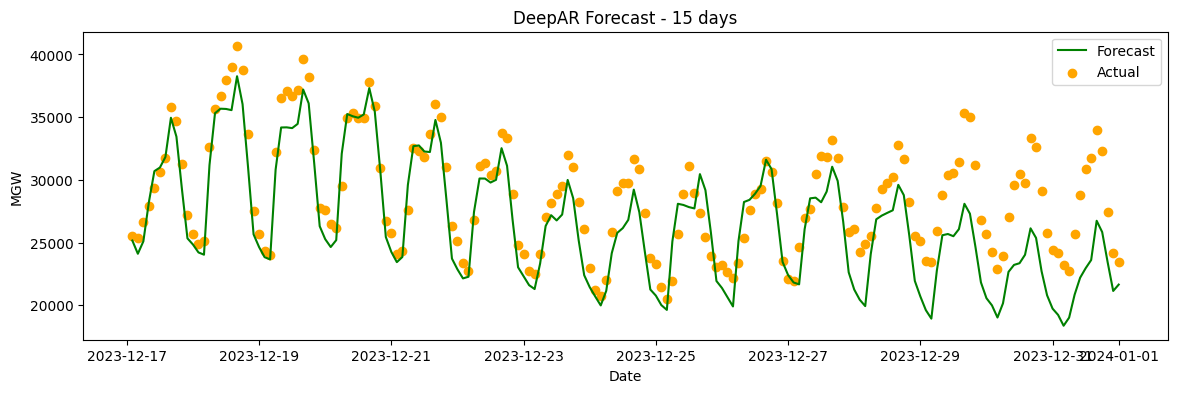

In [ ]:
forecast_plot(forecast_df,test_days_3,days_to_predict)

In [ ]:
mape_3 = mean_absolute_percentage_error(test_days_3["tsd"],forecast_df["median_prediction"])
rmse_3 = root_mean_squared_error(test_days_3["tsd"],forecast_df["median_prediction"])
rsqr_3 = r_squared(test_days_3["tsd"],forecast_df["median_prediction"])
print(f"MAPE with holiday: {round(mape_3,7)}")
print(f"RMSE with holiday: {round(rmse_3,7)}")
print(f"R-squared with holiday: {round(rsqr_3,7)}")

MAPE with holiday: 0.0852378
RMSE with holiday: 3063.4438064
R-squared with holiday: 0.5396823
